# Labeling a full WSI using stardist and dask for distributed computation

## Load the test image

In [6]:
import sys
sys.path.insert(0, "..")

In [7]:
import relabeling

In [8]:
import numpy as np
import zarr
import dask.array as da
import matplotlib.pyplot as plt

Segment and label a full image of a mouse embryo from the Image Data Repository (IDR) https://idr.github.io/ome-ngff-samples/

In [9]:
file_url = "https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.1/6001253.zarr"
z_arr = zarr.open(file_url, mode="r")

Visualize the image DAPI staining channel

In [10]:
z_arr["0"].info

Name,/0
Type,zarr.core.Array
Data type,>u2
Shape,"(1, 2, 297, 1024, 803)"
Chunk shape,"(1, 1, 1, 1024, 803)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.FSStore
No. bytes,976859136 (931.6M)
Chunks initialized,0/594


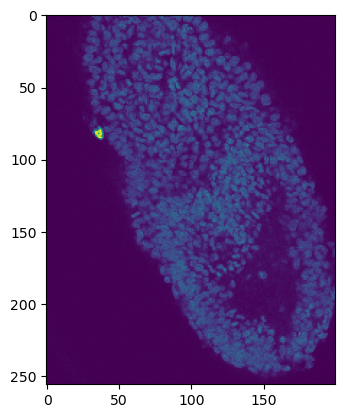

In [11]:
plt.imshow(z_arr["2"][0, 1, 100, ...])

## Load the StarDist models

In [12]:
# Dimension reduction and clustering libraries
from stardist.models import StarDist2D, StarDist3D
from csbdeep.utils import normalize

def stardist3d(im_chunk, model=None):
    labeled_image, _ = model.predict_instances(normalize(im_chunk, 1,99.8, axis=(0, 1, 2)))
    return labeled_image

model_3D = StarDist3D.from_pretrained("3D_demo")

Found model '3D_demo' for 'StarDist3D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.707933, nms_thresh=0.3.


## Try now with the 3D segmentation

Using the DAPI channel of all z-stacks

In [24]:
img_da = da.from_zarr(file_url, component="0")
img_da = img_da[0, 1, 112:116, 512:1024, 0:512]
img_da = da.rechunk(img_da, (4, 256, 256))
img_da

dask.array<rechunk-merge, shape=(4, 512, 512), dtype=>u2, chunksize=(4, 256, 256), chunktype=numpy.ndarray>

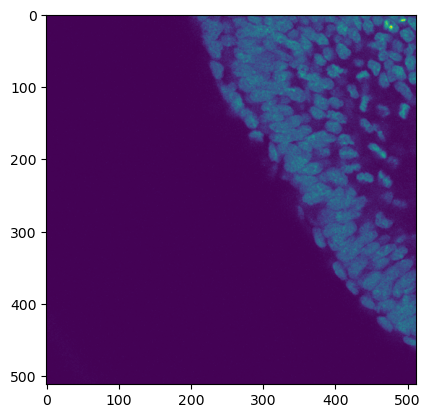

In [25]:
plt.imshow(img_da[0, ...])

## Execute the segmentation and relabeling process

In [26]:
img_da

dask.array<rechunk-merge, shape=(4, 512, 512), dtype=>u2, chunksize=(4, 256, 256), chunktype=numpy.ndarray>

In [27]:
%%time
labels = relabeling.label(
    img_da,
    seg_fn=stardist3d,
    overlap=[4, 8, 8],
    ndim=3,
    persist=".",
    progressbar=True,
    segmentation_fn_kwargs={"model": model_3D}
)

[                                        ] | 0% Completed | 1.11 ms

[########################################] | 100% Completed | 15.65 ss
[########################################] | 100% Completed | 472.88 ms
[########################################] | 100% Completed | 356.86 ms
CPU times: total: 1min 6s
Wall time: 16.9 s


In [28]:
img_da

dask.array<rechunk-merge, shape=(4, 512, 512), dtype=>u2, chunksize=(4, 256, 256), chunktype=numpy.ndarray>

In [29]:
labels

dask.array<getitem, shape=(4, 496, 496), dtype=int32, chunksize=(4, 248, 248), chunktype=numpy.ndarray>

In [30]:
z_tmp = zarr.open("./temp_merged.zarr", mode="r")
z_tmp

<zarr.core.Array (12, 28, 28) int32 read-only>

In [13]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    labels.to_zarr("./labeled.zarr", compressor=zarr.Blosc(clevel=5), overwrite=True)

ValueError: Attempt to save array to zarr with irregular chunking, please call `arr.rechunk(...)` first.